# A “quick” introduction to PyMC3 and Bayesian models, Part I
*In my last post  I talked about Bayesian Statistics and how they can help us quantify uncertainty in data analysis. In this post, I give a “brief”, practical introduction using a specific and hopefully relatable example drawn from real data.*

*For this series of posts, I will assume a basic knowledge of probability (particularly, Bayes theorem), as well as some familiarity with python. You can read up on those subjects here and here, respectively. For a more in-depth probability course, I recommend this book.*

## Waiting for a taxi
We’ve all been there, maybe 15 minutes before a meeting, at 4 AM after a party, or simply when we feel too lazy to walk. And even though apps like Uber have made it relatively painless, there are still times when it is necessary or practical to just wait for a taxi. So we wait, impatiently, probably while wondering how much we will have to wait.

## Modeling
To answer this question in the frame of Bayesian statistics, we first must choose two things:
1. A generative model for our possible observations
2. A prior distribution for the parameters of that model

As the name implies, a generative model is a probability model which is able to generate data that looks a lot like the data we might gather from the phenomenon we’re trying to model. In our case, we need a model that generates data that looks like waiting times.
Fortunately, the exponential distribution, a very well-known continuous distribution, can be used to model waiting times for unscheduled arrivals due to the property of memorylessness, which means that, after waiting any amount of time, the distribution is the same than at the start.

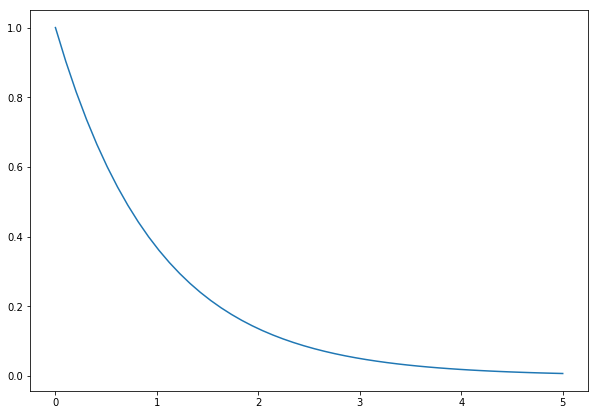

In [1]:
# An example of the exponential distribution. Most of the density is concentrated near zero.

import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(3141) # Just some random seed

exp = ss.expon(scale=1)
x = np.linspace(0, 5, 50)
y = exp.pdf(x)

%matplotlib inline
plt.figure(figsize=(10, 7))
plt.plot(x, y)

This distribution has a single parameter λ, which indicates the expected rate at which the event occurs. We need to describe the prior information or belief about this parameter. For example, we know it’s positive (the taxi can’t arrive before we’re waiting for it!), it has no natural upper bound, and depending on what we know (or believe) about it, we can choose any number of distributions to encode such knowledge. For simplicity, I choose again the exponential, in such a way that the expected waiting time is around 5 minutes.

Here’s how to do it in PyMC3. There’s also a notebook if you prefer to run the code yourself.

In [2]:
# Our generative model. rate_rate is the rate of the rate of arrival. Sorry.

import pymc3 as pm

with pm.Model() as model:
    rate_rate = 5
    rate = pm.Exponential("rate", rate_rate)
    wait_times = pm.Exponential("wait_times", rate)

With these, we’re now able to generate some data that looks like waiting times, and even answer questions about probability. However, there’s no guarantee about the accuracy of the answers. We need data for that.

100%|██████████| 5500/5500 [00:01<00:00, 4953.15it/s]


(array([ 722.,  580.,  427.,  357.,  274.,  241.,  221.,  132.,  146.,
         145.,  107.,  111.,   60.,   65.,   77.,   39.,   49.,   55.,
          35.,   50.,   40.,   31.,   33.,   45.,   29.,   17.,   30.,
          19.,   19.,   14.]),
 array([  0.        ,   0.83333333,   1.66666667,   2.5       ,
          3.33333333,   4.16666667,   5.        ,   5.83333333,
          6.66666667,   7.5       ,   8.33333333,   9.16666667,
         10.        ,  10.83333333,  11.66666667,  12.5       ,
         13.33333333,  14.16666667,  15.        ,  15.83333333,
         16.66666667,  17.5       ,  18.33333333,  19.16666667,
         20.        ,  20.83333333,  21.66666667,  22.5       ,
         23.33333333,  24.16666667,  25.        ]),
 <a list of 30 Patch objects>)

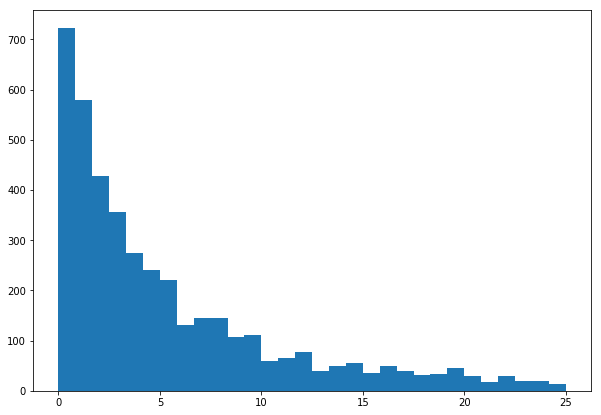

In [3]:
# An example histogram of the waiting times we might generate from our model. 

with model:
    samples = pm.sample(draws=5000, step=pm.Metropolis(), init=None)
plt.figure(figsize=(10, 7))
plt.hist(samples.wait_times, range=(0, 25), bins=30)

## Adding data
*(The data used in this post was gathered from the NYC Taxi & Limousine Commission, and filtered to a specific month and corner, specifically, the first month of 2016, and the corner of 7th avenue and 33rd St)*

Suppose that, miraculously, we have access to a month’s worth of data about taxi pickups, specifically pickups near the corner where we’re waiting. We could look at the time between consecutive pickups and call it the waiting time for the next taxi arrival.

(array([ 1469.,  1200.,   767.,   571.,   458.,   345.,   258.,   197.,
          183.,   153.,   145.,   104.,   111.,    64.,    75.,    73.,
           56.,    34.,    56.,    37.,    22.,    20.,    23.,    27.,
           23.,    25.,    18.,    16.,    12.,    15.]),
 array([  0.        ,   0.83333333,   1.66666667,   2.5       ,
          3.33333333,   4.16666667,   5.        ,   5.83333333,
          6.66666667,   7.5       ,   8.33333333,   9.16666667,
         10.        ,  10.83333333,  11.66666667,  12.5       ,
         13.33333333,  14.16666667,  15.        ,  15.83333333,
         16.66666667,  17.5       ,  18.33333333,  19.16666667,
         20.        ,  20.83333333,  21.66666667,  22.5       ,
         23.33333333,  24.16666667,  25.        ]),
 <a list of 30 Patch objects>)

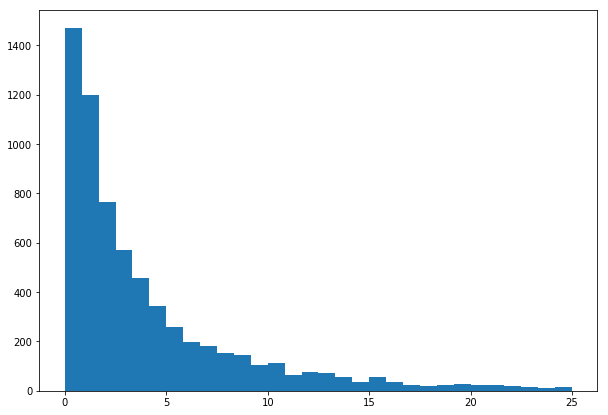

In [4]:
# The histogram of our data. Note the shape of the distribution is similar to our generative model.

import pandas as pd
import dateutil

data = pd.read_csv("data/jan_pickups.csv")
data.pickup = data.pickup.map(dateutil.parser.parse)
wait_time = (data.pickup - data.pickup.shift(1))
wait_mins = wait_time[1:].map(lambda t: t.total_seconds()/60)

plt.figure(figsize=(10, 7))
plt.hist(wait_mins, range=(0, 25), bins=30)

There’s an obvious problem with using these data to model waiting times for a person: that person is not necessarily waiting as soon as the previous taxi leaves, but rather arrives at some point between two pickups. Furthermore, many empty taxis may pass through the corner without picking anyone up. We’ll see how to deal with these problems in later posts. For now though, let’s call it an approximate model and carry on.

Adding the data to our model in PyMC3 is as simple as adding a parameter:

In [5]:
# Adding data. Note the extra parameter “observed” in the wait_times definition.

# We need to remove zeroes or we run into a bug!
model_data = np.array(wait_mins[wait_mins > 0]) 
with pm.Model() as model:
    rate_rate = 5
    rate = pm.Exponential("rate", rate_rate)
    wait_times = pm.Exponential("wait_times", rate, observed=model_data) # Right here!

That’s it, we’re now ready to “train” our model and look at some results.

## Inference and answering questions
Thanks to the Bayes theorem and our generative model, we can now draw samples from the posterior distribution, this is also straightforward in PyMC3

In [6]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, tune=5000, random_se)

100%|██████████| 10000/10000 [00:01<00:00, 6984.08it/s]


We can choose many different methods to draw from this distribution. In this case, I’m using the classic Metropolis algorithm, but PyMC3 also has other MCMC methods such as the Gibbs sampler and NUTS, as well as a great initializer in ADVI.

Let’s look at our posterior distribution:

(array([   18.,   119.,   398.,   977.,  1428.,  1158.,   558.,   273.,
           54.,    17.]),
 array([ 0.14683027,  0.14811339,  0.1493965 ,  0.15067961,  0.15196272,
         0.15324584,  0.15452895,  0.15581206,  0.15709517,  0.15837829,
         0.1596614 ]),
 <a list of 10 Patch objects>)

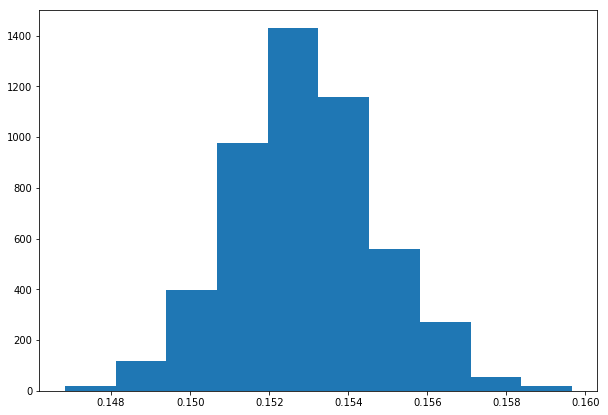

In [7]:
# The posterior distribution for the rate parameter. It encodes the uncertainty about it after observing the data.

plt.figure(figsize=(10, 7))
plt.hist(trace.rate)

With our posterior distribution, we can now answer questions about the rate parameter. For example, its expected value is around 0.153, which works out to about 1 taxi every 6.5 minutes, which is also the expected value of the expected waiting time. We can also look at probability intervals (there’s a 0.93 probability that the rate parameter is between 0.15 and 0.158) or at thresholds (0.99 probability that it is below 0.16).


In [13]:
# How to compute probabilities using the posterior samples. 
# We count the number of cases and divide by the total samples drawn.

post_samples = pd.Series(trace["rate"])

print("Expected rate: {}".format(post_samples.mean()))
print("Probability between 0.15 and 0.158: {}".format(post_samples.map(lambda x: x > 0.15 and x < 0.158).mean()))
print("Probability below 0.159: {}".format(post_samples.map(lambda x: x < 0.159).mean()))

Expected rate: 0.15289928345616693
Probability between 0.15 and 0.158: 0.9366
Probability below 0.159: 0.9984



It is tempting to try and draw direct conclusions about the waiting times from this distribution, but it would be a mistake. The posterior distribution is the representation of our knowledge of the parameters of the model, not about the phenomenon we’re modeling itself. In other words, it tells us how certain we are about our model. A flat posterior means we have not been able to find one good model, but rather that there are many possible models with similar “fit”.

 To be able to answer questions about the phenomenon itself, we need the predictive distribution. This distribution adds the uncertainty about the parameters to the uncertainty present in the model itself, providing us with a proper way to measure the uncertainty of our predictions.

In [12]:
posterior_samples = pm.sample_ppc(model=model, trace=trace, random_seed=4242)["wait_times"]

ps = pd.Series(posterior_samples)
print(ps.mean())
print((ps > 10).mean())
print((ps < 1).mean())

100%|██████████| 5000/5000 [00:00<00:00, 13733.25it/s]

6.57595200519
0.6238
0.2134
0.1378


We can now ask questions such as:
* The expected waiting time: 6.57
* The probability we wait more than 10 minutes: 0.21
* The probability we wait less than a minute: 0.13

Let’s also look at our posterior distribution. Note how it has a heavier tail than our data. This represents our uncertainty about our predictions.

(array([ 604.,  517.,  449.,  380.,  373.,  325.,  256.,  266.,  229.,
         206.,  179.,  140.,  124.,  118.,  115.,   97.,   63.,   74.,
          53.,   60.,   43.,   48.,   37.,   37.,   25.,   26.,   16.,
          21.,   22.,   16.]),
 array([  0.        ,   0.83333333,   1.66666667,   2.5       ,
          3.33333333,   4.16666667,   5.        ,   5.83333333,
          6.66666667,   7.5       ,   8.33333333,   9.16666667,
         10.        ,  10.83333333,  11.66666667,  12.5       ,
         13.33333333,  14.16666667,  15.        ,  15.83333333,
         16.66666667,  17.5       ,  18.33333333,  19.16666667,
         20.        ,  20.83333333,  21.66666667,  22.5       ,
         23.33333333,  24.16666667,  25.        ]),
 <a list of 30 Patch objects>)

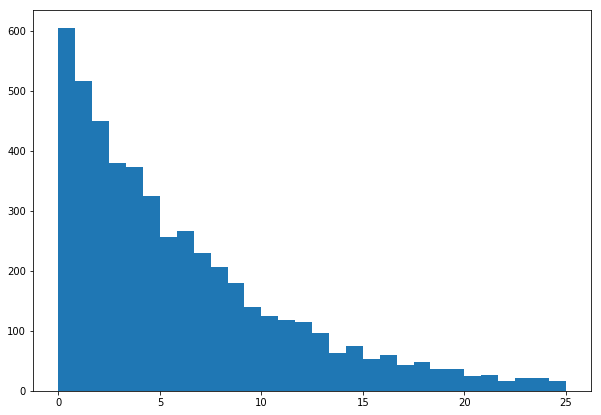

In [10]:
# Our posterior distribution. 
# The slightly heavier tail implies we can’t rule out the probability of observing large waiting times, 
# despite our data not showing a lot of them.

plt.figure(figsize=(10, 7))
plt.hist(posterior_samples, range=(0, 25), bins=30)

## What’s next?
While this model can give us a lot of information, it is not very good at making predictions. This is to be expected, because we’re not adding any feature or covariate that can help us predict our target better.

In the next post, we’ll see how to add features or covariates to a model. We’ll briefly talk about functional forms and will end with a note about prior selection.